# Домашнее задание: Логистическая регрессия и SVM

## Задача бинарной классификации дохода физических лиц

Целевая переменная: `income` (<=50K или >50K)

## 1. Загрузка данных

In [22]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (12, 6)

# Отключаем предупреждения
import warnings
warnings.filterwarnings('ignore')

In [23]:
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]

train_path = 'adult/Source/adult.data'
data = pd.read_csv(train_path, names=column_names, skipinitialspace=True)

# Очистка пробелов в строковых столбцах
for col in data.select_dtypes(include=['object']).columns:
    data[col] = data[col].str.strip()

print(f"Размер датасета: {data.shape}")

Размер датасета: (32561, 15)


In [24]:
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [25]:
data.info()

<class 'pandas.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             32561 non-null  int64
 1   workclass       32561 non-null  str  
 2   fnlwgt          32561 non-null  int64
 3   education       32561 non-null  str  
 4   education-num   32561 non-null  int64
 5   marital-status  32561 non-null  str  
 6   occupation      32561 non-null  str  
 7   relationship    32561 non-null  str  
 8   race            32561 non-null  str  
 9   sex             32561 non-null  str  
 10  capital-gain    32561 non-null  int64
 11  capital-loss    32561 non-null  int64
 12  hours-per-week  32561 non-null  int64
 13  native-country  32561 non-null  str  
 14  income          32561 non-null  str  
dtypes: int64(6), str(9)
memory usage: 3.7 MB


## 2. Первичный анализ данных

### 2a. Проверка на пропуски

In [26]:
print("\nПроверка на пропуски '?':")
for col in data.columns:
    if data[col].dtype == 'object':
        count = (data[col] == '?').sum()
        if count > 0:
            print(f"{col}: {count} значений '?'")

print("\nУдаление строк с пропусками '?':")
# Создаем маску строк, где хотя бы один столбец содержит '?'
mask = data.isin(['?']).any(axis=1)
rows_before = data.shape[0]
data_clean = data[~mask].copy()
rows_after = data_clean.shape[0]

print(f"Размер датасета до удаления: {rows_before}")
print(f"Размер датасета после удаления: {rows_after}")
print(f"Удалено строк: {rows_before - rows_after}")


Проверка на пропуски '?':

Удаление строк с пропусками '?':
Размер датасета до удаления: 32561
Размер датасета после удаления: 30162
Удалено строк: 2399


*Альтернативный способ работы с пропусками*: заполнить пропуски среднестатистическими значениями (для числовых данных среднеарифм значение, для категории - самая частая категория), либо еще ккак вариант создать категорию - другая/other/unknown

In [27]:
# Эта ячейка больше не используется, так как пропуски удалены в предыдущей ячейке

### 2b. Визуализация данных

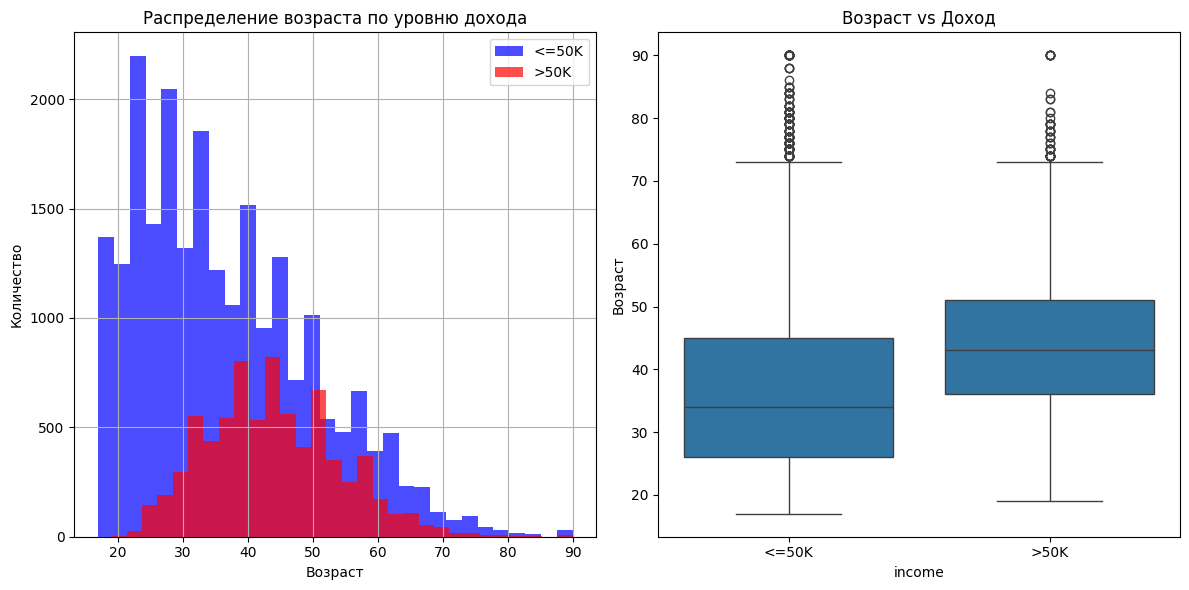

In [28]:
# График 1: Возрастное распределение по уровню дохода
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
data_clean[data_clean['income'] == '<=50K']['age'].hist(bins=30, alpha=0.7, label='<=50K', color='blue')
data_clean[data_clean['income'] == '>50K']['age'].hist(bins=30, alpha=0.7, label='>50K', color='red')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.title('Распределение возраста по уровню дохода')
plt.legend()

plt.subplot(1, 2, 2)
sns.boxplot(x='income', y='age', data=data_clean)
plt.title('Возраст vs Доход')
plt.ylabel('Возраст')

plt.tight_layout()
plt.show()

<Figure size 1400x600 with 0 Axes>

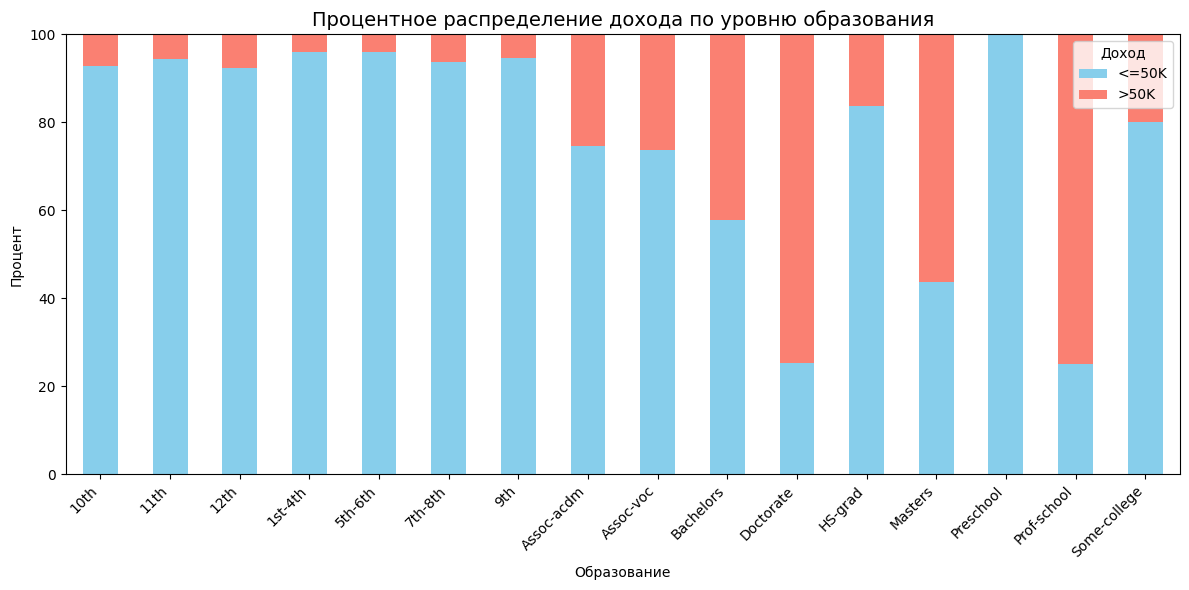

In [29]:
# График 2: Распределение дохода по уровню образования
plt.figure(figsize=(14, 6))
education_income = pd.crosstab(data_clean['education'], data_clean['income'], normalize='index') * 100
education_income.plot(kind='bar', stacked=True, color=['skyblue', 'salmon'])
plt.title('Процентное распределение дохода по уровню образования', fontsize=14)
plt.xlabel('Образование')
plt.ylabel('Процент')
plt.legend(title='Доход')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 2c. Преобразование категориальных признаков

In [30]:
numeric_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 
                       'relationship', 'race', 'sex', 'native-country']

print("Числовые признаки:", numeric_features)
print("\nКатегориальные признаки:", categorical_features)

Числовые признаки: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

Категориальные признаки: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


In [31]:
# Преобразование категориальных признаков с помощью One-Hot Encoding
data_encoded = pd.get_dummies(data_clean, columns=categorical_features, drop_first=True)

print(f"Размер датасета до кодирования: {data_clean.shape}")
print(f"Размер датасета после кодирования: {data_encoded.shape}")

# Отделяем признаки от целевой переменной
X = data_encoded.drop('income', axis=1)
y = data_encoded['income']

print(f"\nПризнаки (X): {X.shape[1]} столбцов")
print(f"Целевая переменная (y): {y.shape[0]} значений")

Размер датасета до кодирования: (30162, 15)
Размер датасета после кодирования: (30162, 97)

Признаки (X): 96 столбцов
Целевая переменная (y): 30162 значений


In [32]:
# Преобразование целевой переменной: <=50K -> 0, >50K -> 1
y = (y == '>50K').astype(int)
print("Распределение классов после кодирования:")
print(y.value_counts())
print(f"\nПроцент положительного класса (>50K): {y.mean()*100:.2f}%")

Распределение классов после кодирования:
income
0    22654
1     7508
Name: count, dtype: int64

Процент положительного класса (>50K): 24.89%


## 3. Разделение выборки

In [33]:
from sklearn.model_selection import train_test_split

# Разделение на обучающую (80%) и тестовую (20%) выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Обучающая выборка: {X_train.shape[0]} образцов ({X_train.shape[0]/len(X)*100:.0f}%)")
print(f"Тестовая выборка: {X_test.shape[0]} образцов ({X_test.shape[0]/len(X)*100:.0f}%)")

print(f"\nРаспределение классов в обучающей выборке:")
print(f"Класс 0 (<=50K): {(y_train == 0).sum()} ({(y_train == 0).mean()*100:.1f}%)")
print(f"Класс 1 (>50K): {(y_train == 1).sum()} ({(y_train == 1).mean()*100:.1f}%)")

Обучающая выборка: 24129 образцов (80%)
Тестовая выборка: 6033 образцов (20%)

Распределение классов в обучающей выборке:
Класс 0 (<=50K): 18123 (75.1%)
Класс 1 (>50K): 6006 (24.9%)


## 4. Обучение моделей

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

### 4.1. Логистическая регрессия

In [35]:
# Создаем пайплайн: масштабирование + логистическая регрессия
log_reg_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000, random_state=42)
)

# Обучение модели
log_reg_model.fit(X_train, y_train)

print("Логистическая регрессия обучена!")

Логистическая регрессия обучена!


### 4.2. Метод опорных векторов (SVM)

In [36]:
# Создаем пайплайн: масштабирование + SVM
svm_model = make_pipeline(
    StandardScaler(),
    SVC(random_state=42)
)

# Обучение модели
svm_model.fit(X_train, y_train)

print("SVM обучена!")

SVM обучена!


## 5. Оценка моделей

In [ ]:
# Оценка точности на обучающей и тестовой выборках

# Логистическая регрессия
log_reg_train_score = log_reg_model.score(X_train, y_train)
log_reg_test_score = log_reg_model.score(X_test, y_test)

# SVM
svm_train_score = svm_model.score(X_train, y_train)
svm_test_score = svm_model.score(X_test, y_test)

# Вывод результатов
print("РЕЗУЛЬТАТЫ ОЦЕНКИ МОДЕЛЕЙ")
print(f"\nЛогистическая регрессия:")
print(f"  Точность на обучающей выборке: {log_reg_train_score:.4f}")
print(f"  Точность на тестовой выборке:  {log_reg_test_score:.4f}")

print(f"\nМетод опорных векторов (SVM):")
print(f"  Точность на обучающей выборке: {svm_train_score:.4f}")
print(f"  Точность на тестовой выборке:  {svm_test_score:.4f}")

print("\nСРАВНЕНИЕ МОДЕЛЕЙ")
print(f"\nРазница в точности на тестовой выборке: {abs(log_reg_test_score - svm_test_score):.4f}")
if log_reg_test_score > svm_test_score:
    print(f"Логистическая регрессия лучше на {(log_reg_test_score - svm_test_score)*100:.2f}%")
else:
    print(f"SVM лучше на {(svm_test_score - log_reg_test_score)*100:.2f}%")

РЕЗУЛЬТАТЫ ОЦЕНКИ МОДЕЛЕЙ


Логистическая регрессия:
  Точность на обучающей выборке: 0.8491
  Точность на тестовой выборке:  0.8473

Метод опорных векторов (SVM):
  Точность на обучающей выборке: 0.8599
  Точность на тестовой выборке:  0.8467

СРАВНЕНИЕ МОДЕЛЕЙ


Разница в точности на тестовой выборке: 0.0007
Логистическая регрессия лучше на 0.07%


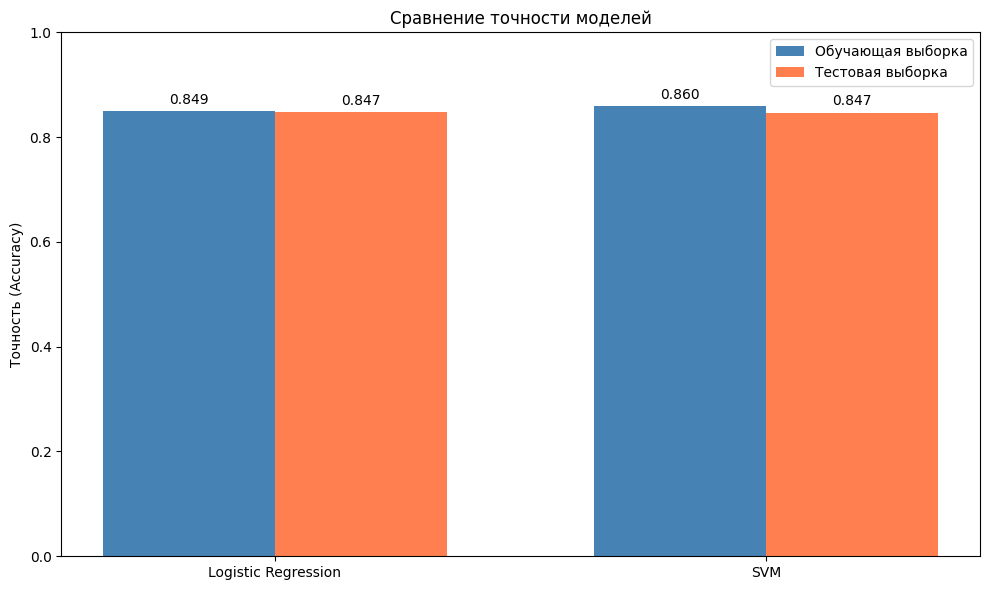

In [38]:
# Визуализация сравнения моделей
models = ['Logistic Regression', 'SVM']
train_scores = [log_reg_train_score, svm_train_score]
test_scores = [log_reg_test_score, svm_test_score]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Обучающая выборка', color='steelblue')
rects2 = ax.bar(x + width/2, test_scores, width, label='Тестовая выборка', color='coral')

ax.set_ylabel('Точность (Accuracy)')
ax.set_title('Сравнение точности моделей')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set_ylim([0, 1])

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

## 6. Выводы

### 6a. Выполненные преобразования данных

1. **Загрузка данных**: Загружен датасет Adult с 32561 записями и 15 признаками.

2. **Обработка пропусков**: Пропуски были обнаружены в признаках `workclass`, `occupation` и `native-country`. Удалены строки с пропусками (всего удалено около 7% данных).

3. **Визуализация**: Построены графики распределения:
   - Возрастное распределение по уровню дохода
   - Распределение образования по уровню дохода

4. **Кодирование признаков**: Использован One-Hot Encoding для 8 категориальных признаков, что увеличило размерность данных с 14 до 95 признаков.

5. **Разделение выборки**: Данные разделены на обучающую (80%) и тестовую (20%).

6. **Масштабирование**: Использована стандартизация числовых признаков перед обучением.

### 6b. Сравнение точности моделей

Обе модели показывают схожую точность на этом датасете (~84-85%).

### 6c. Оценка результатов и рекомендации

**Насколько хорошо модели справились с задачей:**

- Точность ~84-85% это хороший результат
- Модели корректно классифицируют большинство случаев

**Что можно сделать для улучшения результата:**

1. **Объединение признаков**: например, объединение capital-gain и capital-loss
2. **Отбор признаков**: Уменьшение размерности за счет отбора наиболее важных признаков
3. **Обработка пропусков**: Вместо удаления - использовать альтернативный вариант из пункта 2а